In [1]:
# read in libraries
import tensorflow as tf
from tensorflow.keras import backend, models, layers, optimizers
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import display
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
from tensorflow.keras.models import Model
from shutil import copyfile
import scipy
np.random.seed(42)

In [22]:
base_dir = 'C:/Users/asus/Documents/Bachelor Project/bsc project'  
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, rescale = 1./255., shear_range = 30, zoom_range = 0.3, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

test_generator = test_datagen.flow_from_directory(test_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224), shuffle=False)

Found 778 images belonging to 30 classes.
Found 193 images belonging to 30 classes.


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=(224, 224,3), include_top=False, weights="imagenet")
for layer in base_model.layers:
    if not layer.name.startswith("block5_conv"):
        layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Connect the VGG output to the fully connected layers
model = base_model.output
pool = GlobalAveragePooling2D()(model)
#dense_1 = layers.Dense(512, activation = 'relu')(pool)
output = layers.Dense(30, activation = 'softmax')(pool)

In [6]:
complete_model = models.Model(inputs=base_model.input, outputs=output)

complete_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['acc'])

In [18]:
for layer in complete_model.layers:
    layer.trainable = True
complete_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['acc'])

39/39 [==============================] - 1266s 33s/step - loss: 0.2466 - acc: 0.9203 - val_loss: 0.6980 - val_acc: 0.8342
Runtime of the program is 1266.731051683426


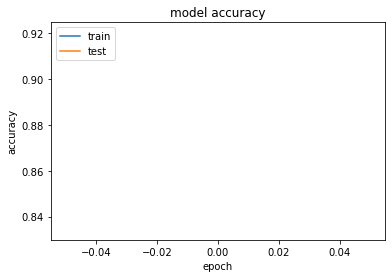

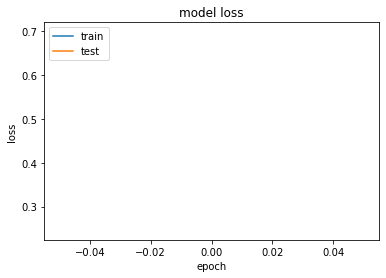

In [28]:
import matplotlib.pyplot as plt
import time

start = time.time()
history = complete_model.fit(train_generator, validation_data = test_generator, epochs = 1,
        callbacks=[EarlyStopping(monitor='val_acc', patience = 1, restore_best_weights = True)])
end = time.time()
print(f"Runtime of the program is {end - start}")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
a = history.history['acc'].copy()
b = history.history['val_acc'].copy()
c = history.history['loss'].copy()
d = history.history['val_loss'].copy()

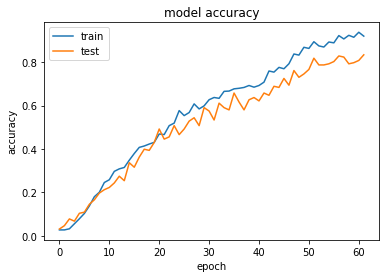

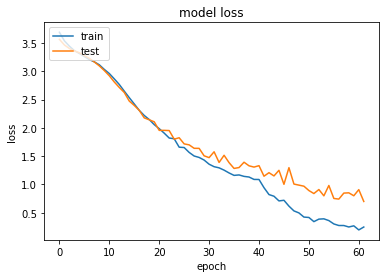

In [29]:
a = a + history.history['acc']
b = b + history.history['val_acc']
c = c + history.history['loss']
d = d + history.history['val_loss']
# summarize history for accuracy
plt.plot(a)
plt.plot(b)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(c)
plt.plot(d)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the test accuracy and test loss of the model
test_loss, test_acc = complete_model.evaluate(test_generator)
print('Model testing accuracy/testing loss:', test_acc, " ", test_loss)

#Confution Matrix and Classification Report
Y_pred = complete_model.predict(test_generator, 193 // 20+1)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['acerolas','apples','apricots','avocados','bananas','blackberries','blueberries','cantaloupes','cherries','coconuts','figs','grapefruits','grapes','guava','kiwifruit','lemons','limes','mangos','olives','oranges','passionfruit','peaches','pears','pineapples','plums','pomegranates','raspberries','strawberries','tomatoes','watermelons']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

10/10 [==============================] - 80s 8s/step - loss: 0.6980 - acc: 0.8342
Model testing accuracy/testing loss: 0.8341968655586243   0.6979871988296509
[28 28  0 25  0  1  1  1  1  1  1 24  1  1 24  2  2  2  2  2  2  2 21  3
  3  4  4  4  4  4  5  5  5  5  6 20  5  5  6  6  6  6  6  6 24  7  7  7
  7  8  1  8  8  8 24 27  8  8  8  9 10 22 11 11 11 11 11 11 11 11 12 12
 12 12  6 12 13 13 10 10  1 14 14 14 14 14 14 14 14 15 15 19 19  7 22 16
 16 16 16 16 16 16 16 17 17 17 17 17 18  8 18  1 18 18 12 18 18 19 19 19
 19 19 19 19 19 20 20 21 21 21  2  2 21 24 22 22 22 22 22 22 23 23 23 23
 23 24 24 24  1 25 25 25 25 25 25 25 25  1 26 26 26 26 26 26 26 26 27 27
 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 29 13 21 23 29
 29]
Confusion Matrix
[[ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  2  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  

In [30]:
# serialize to JSON
json_file = complete_model.to_json()
with open("C:/Users/asus/Documents/Bachelor Project/bsc project/vgg_fine_tuning_62.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
complete_model.save_weights("vgg_fine_tuning_62.h5")

In [3]:
from tensorflow.keras.models import model_from_json

# load json and create model
file = open("C:/Users/asus/Documents/Bachelor Project/bsc project/vgg.json", 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights("vgg.h5")

loaded_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss = 'categorical_crossentropy', metrics = ['acc'])

test_loss, test_acc = loaded_model.evaluate(test_generator)
print('Model testing accuracy/testing loss:', test_acc, " ", test_loss)
complete_model = loaded_model

10/10 [==============================] - 70s 7s/step - loss: 1.1108 - acc: 0.8187
Model testing accuracy/testing loss: 0.818652868270874   1.1107587814331055
